<a href="https://colab.research.google.com/github/sahay-saurav/ashrae-energy-prediction/blob/main/great_energy_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Data and EDA

## Importing Data from Kaggel and Unzip

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json # Allocate the required permission for this file.
! kaggle competitions download -c ashrae-energy-prediction # Downloading the project specific data

  0% 0.00/1.27M [00:00<?, ?B/s]
100% 1.27M/1.27M [00:00<00:00, 85.6MB/s]
 97% 116M/120M [00:01<00:00, 110MB/s]  
100% 120M/120M [00:01<00:00, 112MB/s]
  0% 0.00/44.5k [00:00<?, ?B/s]
100% 44.5k/44.5k [00:00<00:00, 44.4MB/s]
 91% 151M/167M [00:01<00:00, 78.0MB/s]
100% 167M/167M [00:01<00:00, 105MB/s] 
  0% 0.00/2.53M [00:00<?, ?B/s]
100% 2.53M/2.53M [00:00<00:00, 170MB/s]
 91% 80.0M/88.4M [00:00<00:00, 118MB/s]
100% 88.4M/88.4M [00:00<00:00, 121MB/s]


## Unzipping files

In [ ]:
! unzip train.csv.zip
! unzip weather_train.csv.zip
! unzip test.csv.zip
! unzip weather_test.csv.zip
! unzip sample_submission.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  weather_train.csv.zip
  inflating: weather_train.csv       
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  weather_test.csv.zip
  inflating: weather_test.csv        
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as datetime
sns.set()




### Reading data in Pandas and creating dataframes

In [ ]:
df_data = pd.read_csv("train.csv")
df_train_weather = pd.read_csv("weather_train.csv")
df_building_metadata = pd.read_csv("building_metadata.csv")


In [ ]:
df_train = pd.merge(df_data,df_building_metadata,how='outer', on ="building_id")
df_train = pd.merge(df_train,df_train_weather,how="outer",on= ["site_id","timestamp"]) # creating one final file with all training data together
df_train["meter_reading"] = np.where(df_train["site_id"]==0,df_train["meter_reading"]*0.2931,df_train["meter_reading"]) # For the site 0 electric meter readings are in kBTU. Multiplication by 0.2931 is required to get to model inputs into kWh like the other sites

In [ ]:
df_train.meter_reading.describe()

count    2.021610e+07
mean     2.096420e+03
std      1.532356e+05
min      0.000000e+00
25%      1.794500e+01
50%      7.485000e+01
75%      2.503000e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

In [ ]:
df_train.meter_reading.quantile(q=.999)

38671.9

In [ ]:
x = [df_train.meter_reading.quantile(q=.75),df_train.meter_reading.quantile(q=.85),df_train.meter_reading.quantile(q=.95),df_train.meter_reading.quantile(q=.99),df_train.meter_reading.quantile(q=.999),df_train.meter_reading.quantile(q=.9999),df_train.meter_reading.quantile(q=.99999),df_train.meter_reading.quantile(q=1.0)]

In [ ]:
x

[250.3,
 489.334,
 1455.08,
 5178.24,
 38671.9,
 6719767.2759874165,
 19449967.802000046,
 21904700.0]

In [ ]:
df_train[df_train["meter_reading"]== df_train.meter_reading.max()] # getting very high values

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
14405851,1099.0,2.0,2016-06-13 09:00:00,21904700.0,13,Education,332884.0,NaN,NaN,19.4,NaN,17.2,0.0,1014.4,50.0,6.2


In [ ]:
df_train.drop(df_train[df_train["building_id"]== 1099].index, inplace= True) # dropping outlier

In [ ]:
df_train.shape


(20198669, 16)

In [ ]:
df_train.shape

(20198669, 16)

In [ ]:
df_train.meter.unique() # 0: electricity, 1: chilledwater, 2: steam, 3: hotwater

array([ 0.,  1.,  3.,  2., nan])

In [ ]:
df_train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0.0,0.0,2016-01-01 00:00:00,0.0,0,Education,7432.0,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1.0,0.0,2016-01-01 00:00:00,0.0,0,Education,2720.0,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2.0,0.0,2016-01-01 00:00:00,0.0,0,Education,5376.0,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3.0,0.0,2016-01-01 00:00:00,0.0,0,Education,23685.0,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4.0,0.0,2016-01-01 00:00:00,0.0,0,Education,116607.0,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


In [ ]:
# sns.scatterplot(df_train.meter_reading,df_train.timestamp) # dont run as this dont give any fruitful result

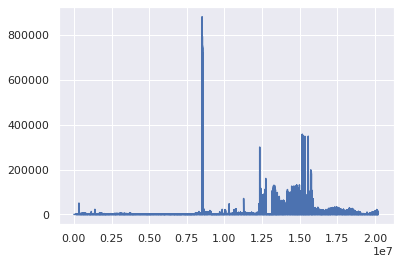

In [ ]:
plt.plot(df_train.meter_reading)

Text(0.5, 1.0, 'Meter Reading')

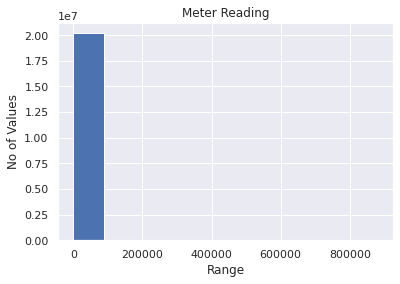

In [ ]:
plt.hist(df_train.meter_reading)
plt.xlabel("Range")
plt.ylabel("No of Values")
plt.title("Meter Reading")

In [ ]:
df_train.meter_reading.count()

20198534

#### Log meter reading

In [ ]:
## Important to create new varaibale
df_train["log_meter_readging"]= np.log10(df_train["meter_reading"]+1) # adding one more column of log meter reading, as all of the data is positive so simply adding "1" with data will take care of problem of non defination of log0

### Exploratory Data Analysis

Text(0.5, 1.0, 'Log Meter Reading')

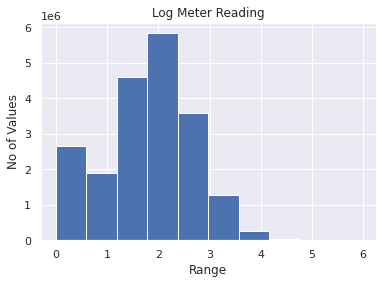

In [ ]:
plt.hist(df_train.log_meter_readging)
plt.xlabel("Range")
plt.ylabel("No of Values")
plt.title("Log Meter Reading")

In [ ]:
df_train.isnull().sum() # checking for missing values

building_id                135
meter                      135
timestamp                    0
meter_reading              135
site_id                      0
primary_use                135
square_feet                135
year_built            12110214
floor_count           16691736
air_temperature          96654
cloud_coverage         8816843
dew_temperature         100136
precip_depth_1_hr      3749095
sea_level_pressure     1231427
wind_direction         1448617
wind_speed              143672
log_meter_readging         135
dtype: int64

In [ ]:
df_train.count()

building_id           20198534
meter                 20198534
timestamp             20198669
meter_reading         20198534
site_id               20198669
primary_use           20198534
square_feet           20198534
year_built             8088455
floor_count            3506933
air_temperature       20102015
cloud_coverage        11381826
dew_temperature       20098533
precip_depth_1_hr     16449574
sea_level_pressure    18967242
wind_direction        18750052
wind_speed            20054997
log_meter_readging    20198534
dtype: int64

In [ ]:
df_train.meter_reading.describe()

count    2.019853e+07
mean     4.394003e+02
std      4.223066e+03
min      0.000000e+00
25%      1.790522e+01
50%      7.466095e+01
75%      2.495120e+02
max      8.803740e+05
Name: meter_reading, dtype: float64

In [ ]:
df_train["timestamp"] = pd.to_datetime(df_train["timestamp"]) # Converting object type to datetime format for further analysis

In [ ]:
df_train["hour"] = df_train["timestamp"].dt.hour # extrating hour from date time and creating new Varibale

In [ ]:
df_train["DayofWeek"] = df_train["timestamp"].dt.dayofweek # extrating day of week from date time and creating new Varibale, Monday 0

In [ ]:
df_train["Month"] = df_train["timestamp"].dt.month # extrating month from date time and creating new Varibale

In [ ]:
df_hour= df_train.groupby(['hour']).log_meter_readging.mean().reset_index() # creating new data set only for plotting

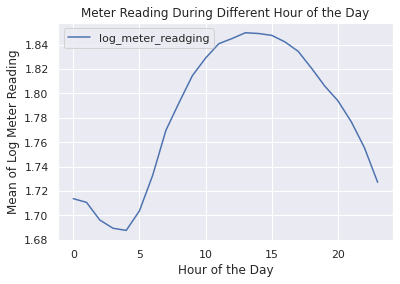

In [ ]:
# Meter Reading During Different Hour of the Day
df_hour.plot("hour","log_meter_readging")
plt.xlabel("Hour of the Day")
plt.ylabel("Mean of Log Meter Reading")
plt.title("Meter Reading During Different Hour of the Day")
plt.show()

We can see that the meter reading is minimum at around 4 hours while it starts ramping sharply from 5 Hrs and ramps quickly up to 9 Hrs, after that it ramps up relatively slowly up to 13 hours, post that it starts ramping down. It ramps down at a significantly faster rate from 17 Hours onwards.  We can also see that mean meter reading normally remains higher from 9 Hrs upto 17 Hrs i.e during work hour

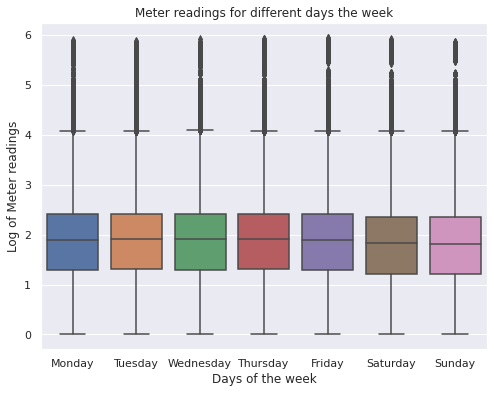

In [ ]:
#Meter readings for different days the week
plt.figure(figsize=(8,6))
day_labels= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plot = sns.boxplot(x=df_train.DayofWeek, y=df_train.log_meter_readging)
plot.set_xticklabels(day_labels)
plt.xlabel("Days of the week")
plt.ylabel("Log of Meter readings")
plt.title("Meter readings for different days the week")
plt.show()

Variation of meter reading for different days are plotted, here we can see that for Weekend (i.e Saturday and Sunday) the 25 percentile, median and 75 percentile value is slightly lower than weekdays however it is not significant enough to make any conclusion.  

In [ ]:
df_month= df_train.groupby(['Month']).log_meter_readging.mean().reset_index() # creating new data set only for plotting

<Figure size 576x432 with 0 Axes>

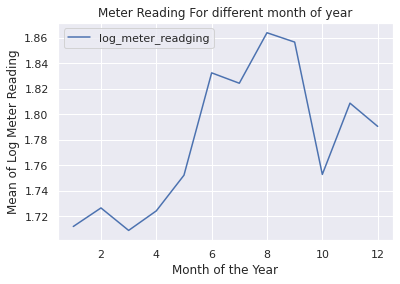

In [ ]:
#Meter Reading For different month of year
plt.figure(figsize=(8,6))
df_month.plot("Month","log_meter_readging")
plt.xlabel("Month of the Year")
plt.ylabel("Mean of Log Meter Reading")
plt.title("Meter Reading For different month of year")
plt.show()

The average monthly consumption is plotted and it is observed that it is minimal from January to April and least in March. Post-April it increases rapidly and the maximum value is observed in August, after which it again starts dropping.   in the initial months and then rises after April in the onset of spring. Although the plot ends in December however if we connect December and January a very shape drop between these two months is also noticed. 

Text(0.5, 1.0, 'Number of Different Types of Meter')

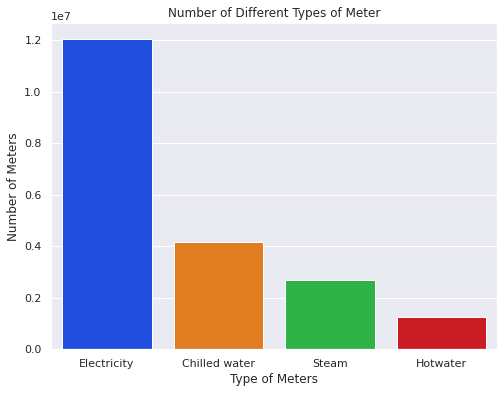

In [ ]:
#Number of Different Types of Meter
plt.figure(figsize=(8,6))
meter_labels= ['Electricity','Chilled water','Steam','Hotwater']
plot=sns.countplot(x='meter', data=df_train, palette="bright")
plot.set_xticklabels(meter_labels)
plt.ylabel("Number of Meters")
plt.xlabel("Type of Meters")
plt.title("Number of Different Types of Meter")

we are analyzing the different types of meters and found that most of the meters are measuring electricity followed by Chilled water and Steam and least number of meters are associated with hot water. 

Text(0.5, 1.0, 'Average Meter readings recorded by meter types')

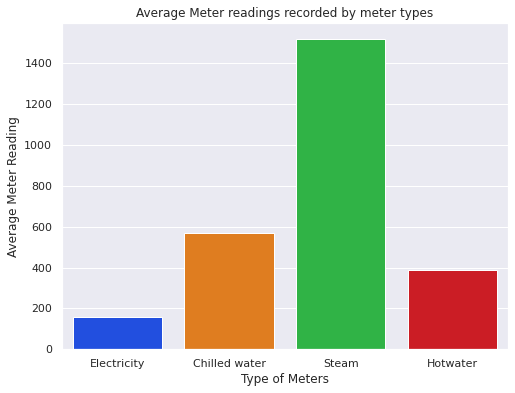

In [ ]:
# Average Meter readings recorded by meter types
plt.figure(figsize=(8,6))
df_meter_type= df_train.groupby('meter').meter_reading.mean().reset_index()
meter_labels= ['Electricity','Chilled water','Steam','Hotwater']
plot = sns.barplot(x='meter', y='meter_reading', data=df_meter_type, palette='bright')
plot.set_xticklabels(meter_labels)
plt.xlabel("Type of Meters")
plt.ylabel("Average Meter Reading")
plt.title("Average Meter readings recorded by meter types")

Text(0.5, 1.0, 'Total Meter readings recorded by meter types')

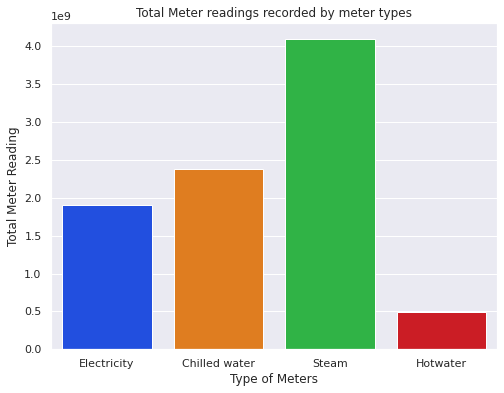

In [ ]:
#Total Meter readings recorded by meter types
plt.figure(figsize=(8,6))
df_meter_type_1= df_train.groupby('meter').meter_reading.sum().reset_index()
meter_labels= ['Electricity','Chilled water','Steam','Hotwater']
plot = sns.barplot(x='meter', y='meter_reading', data=df_meter_type_1, palette='bright')
plot.set_xticklabels(meter_labels)
plt.xlabel("Type of Meters")
plt.ylabel("Total Meter Reading")
plt.title("Total Meter readings recorded by meter types")

Here we can see that both total energy consumption, as well as average energy consumption, is highest for steam meter while average energy consumption is minimum for Electricity meter and Total energy consumption is minimum for Hot water meter.

Text(0.5, 1.0, 'Number of Meters installed at Different Building')

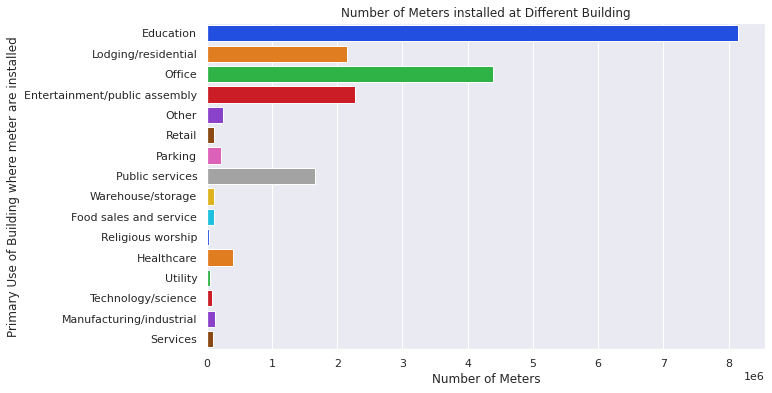

In [ ]:
# Number of Meters installed at Different Building
plt.figure(figsize=(10,6))
plot=sns.countplot(y='primary_use', data=df_train, palette="bright") # using x axis for building type is resulting in overlap of indices
plt.ylabel("Primary Use of Building where meter are installed")
plt.xlabel("Number of Meters")
plt.title("Number of Meters installed at Different Building")

Plotting the location of where these meters are installed. We found that most numbers of meters are at Educational building followed by offices, Entertainment/public assembly. While the Religious worship place and Utilities are represented by the least number of meters. 

Text(0.5, 1.0, 'Mean Meter Reading at Different Site')

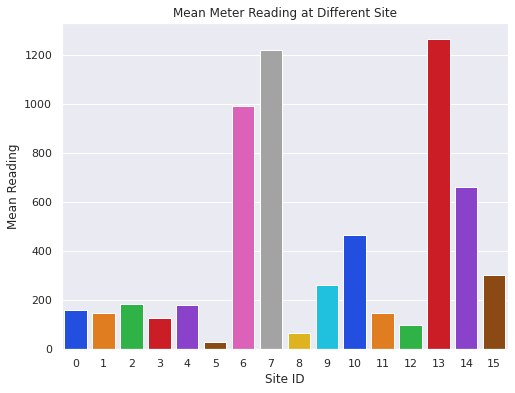

In [ ]:
# Mean Meter Reading at Different Site
plt.figure(figsize=(8,6))
df_meter_site= df_train.groupby('site_id').meter_reading.mean().reset_index()
plot = sns.barplot(x='site_id', y='meter_reading', data=df_meter_site, palette='bright')
plt.xlabel("Site ID")
plt.ylabel("Mean Reading")
plt.title("Mean Meter Reading at Different Site")

Text(0.5, 1.0, 'Total Meter Reading at Different Site')

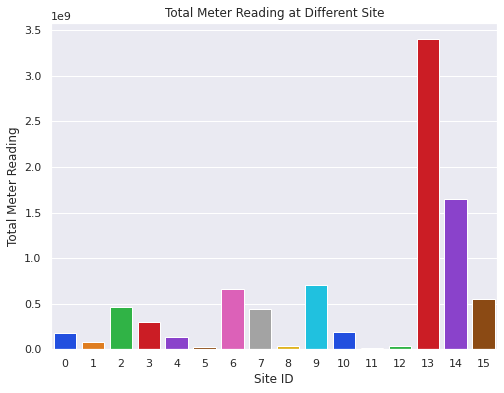

In [ ]:
#Total Meter Reading at Different Site
plt.figure(figsize=(8,6))
df_meter_site= df_train.groupby('site_id').meter_reading.sum().reset_index()
plot = sns.barplot(x='site_id', y='meter_reading', data=df_meter_site, palette='bright')
plt.xlabel("Site ID")
plt.ylabel("Total Meter Reading")
plt.title("Total Meter Reading at Different Site")

Plotting the Mean meter reading and Total meter reaading at Different Site Id we found that while mean meter reading at Site 7 and Site 13 are highest and very close to each other. The Total meter reading is very high for location number 13. 

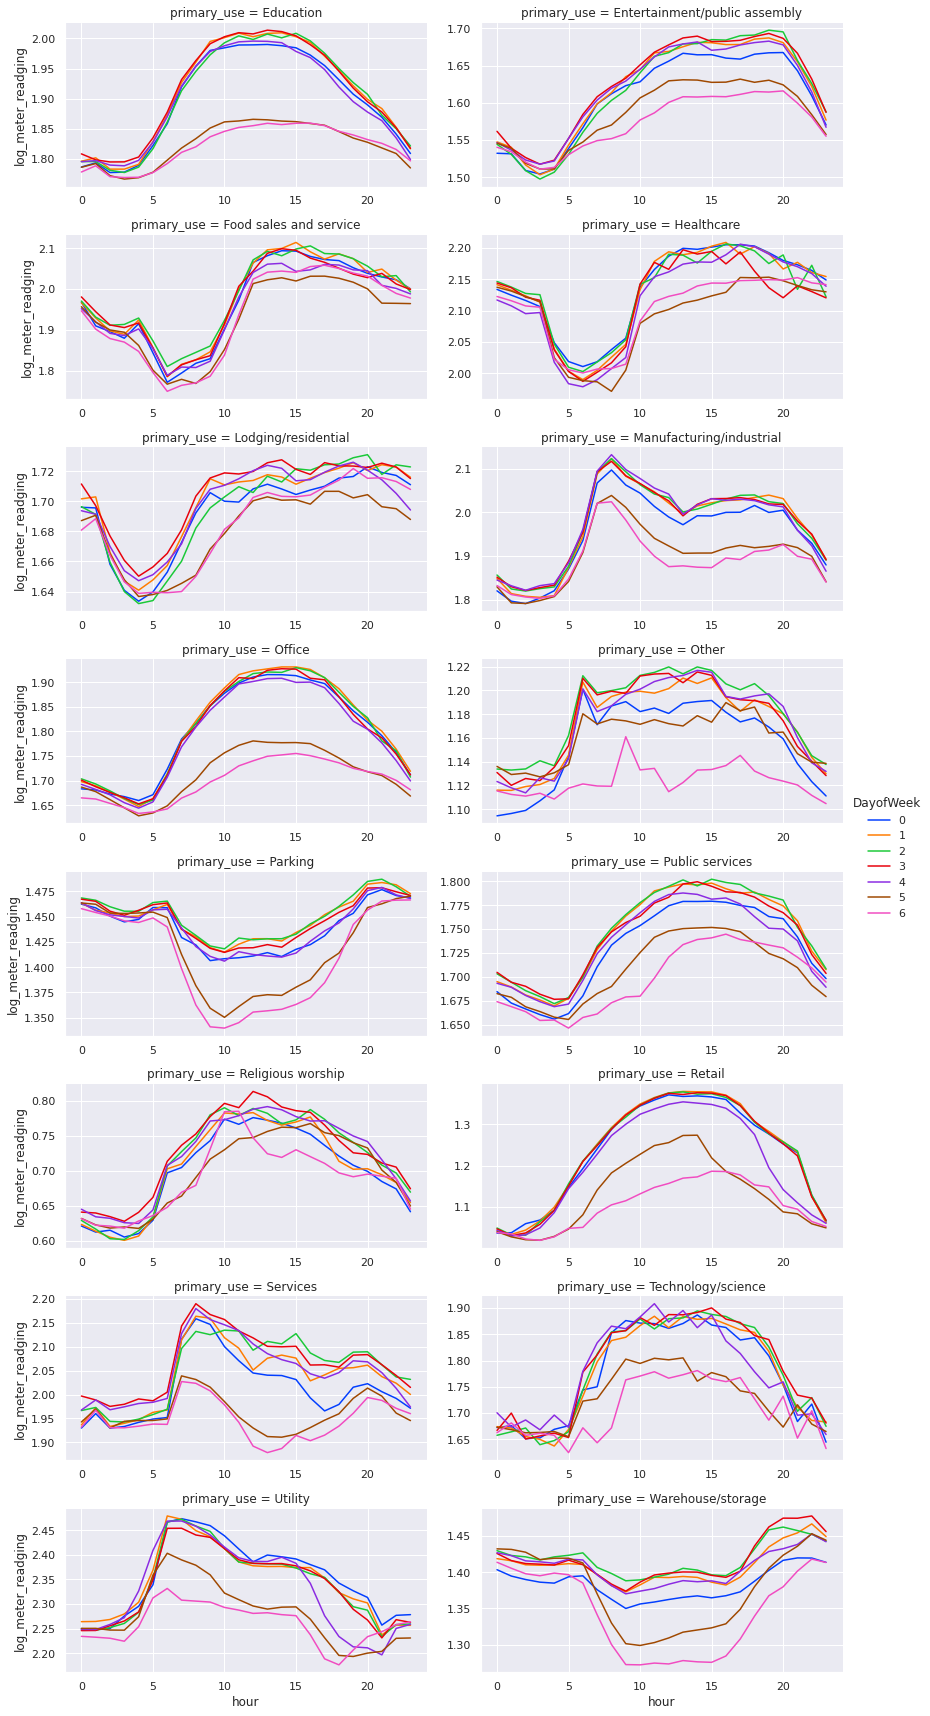

In [ ]:
# Hourly Energy Consumptions during different Days for different Primay use
df_type_day_use= df_train.groupby(['hour', 'primary_use',"DayofWeek"]).log_meter_readging.mean().reset_index()
p= sns.FacetGrid(df_type_day_use, col='primary_use', hue="DayofWeek",col_wrap=2, height=3, aspect=2,sharey=False, sharex=False, palette="bright", legend_out=True)
p.map(sns.lineplot,'hour', 'log_meter_readging')
p.add_legend()
plt.show()

we have plotted the log of average hourly usage for each of the primary usage category with different days of week. Following can be observed


*   Almost for all building type barring Food sales and service and Lodging/residential the consumption during the weekday is significantly higher than that of weekend. This indicates that consumption patter during holiday and working day is different and this factor needs to be considered in modeling. However, in absence of information about exact location of the building like country,  state etc, the holiday information cannot be utilized to its fullest.
*	During the working day usage for educational institutes have the peak usage from morning 9 am until 4 pm and then the usage drops. This is expected as most educational institutes are operational during day time only.
*	The consumption for enetertainmet/public assembly starts rising after 7 AM on weekday and after 10 AM on weekend  continues to remain high upto 8 PM.
*	Food Sales and Service remains almost unaffected by holiday the consumption starts ramping from 10 AM and peaking at round 3 PM its consumption remains higher side on during early night hour also.
*	Health care witness a very Sharpe rise at around 9 AM and remain on higher side post that.
*	Residential building consumption starts increasing from 6 AM and remains stable from 10 AM onwards 
*	Manufacturing/Industrial sector demand witness a very sharp peak from 5 AM and peaks at 9 AM after that it reduces slightly and remains stable upto 8 PM
*	The office buildings, consume most of the energy in the daytime mainly from 10 AM to 5 PM. While consumption is significantly less during the weekend. 
*	For other primary use type building the consumption peaks at around 6 AM and remain high upto 8 PM.
*	For parking Consumption is significantly lower during weekends. Further unlike other building type consumption is minimum during the day time. 
*	For public services consumption starts ramping from 5 AM and becomes maximum around 3 PM after that it starts reducing.
*	For religious worship demand is higher during the day time with peaking in afternoon.
*	For Relatil demand starts ramping sharply from 5 AM to 10 AM after that it ramin stable upto 6 PM 
*	For service demand peaks at around 8 AM and after that it reduces slowly
*	For Technology/Science demand remain high from 9 AM to 6 PM.
*	For utility demand peaks at around 6 AM and after that it reduces slowly
*	For warehouse/storage demand remains on lower side during the day and it peak normally during early night hours


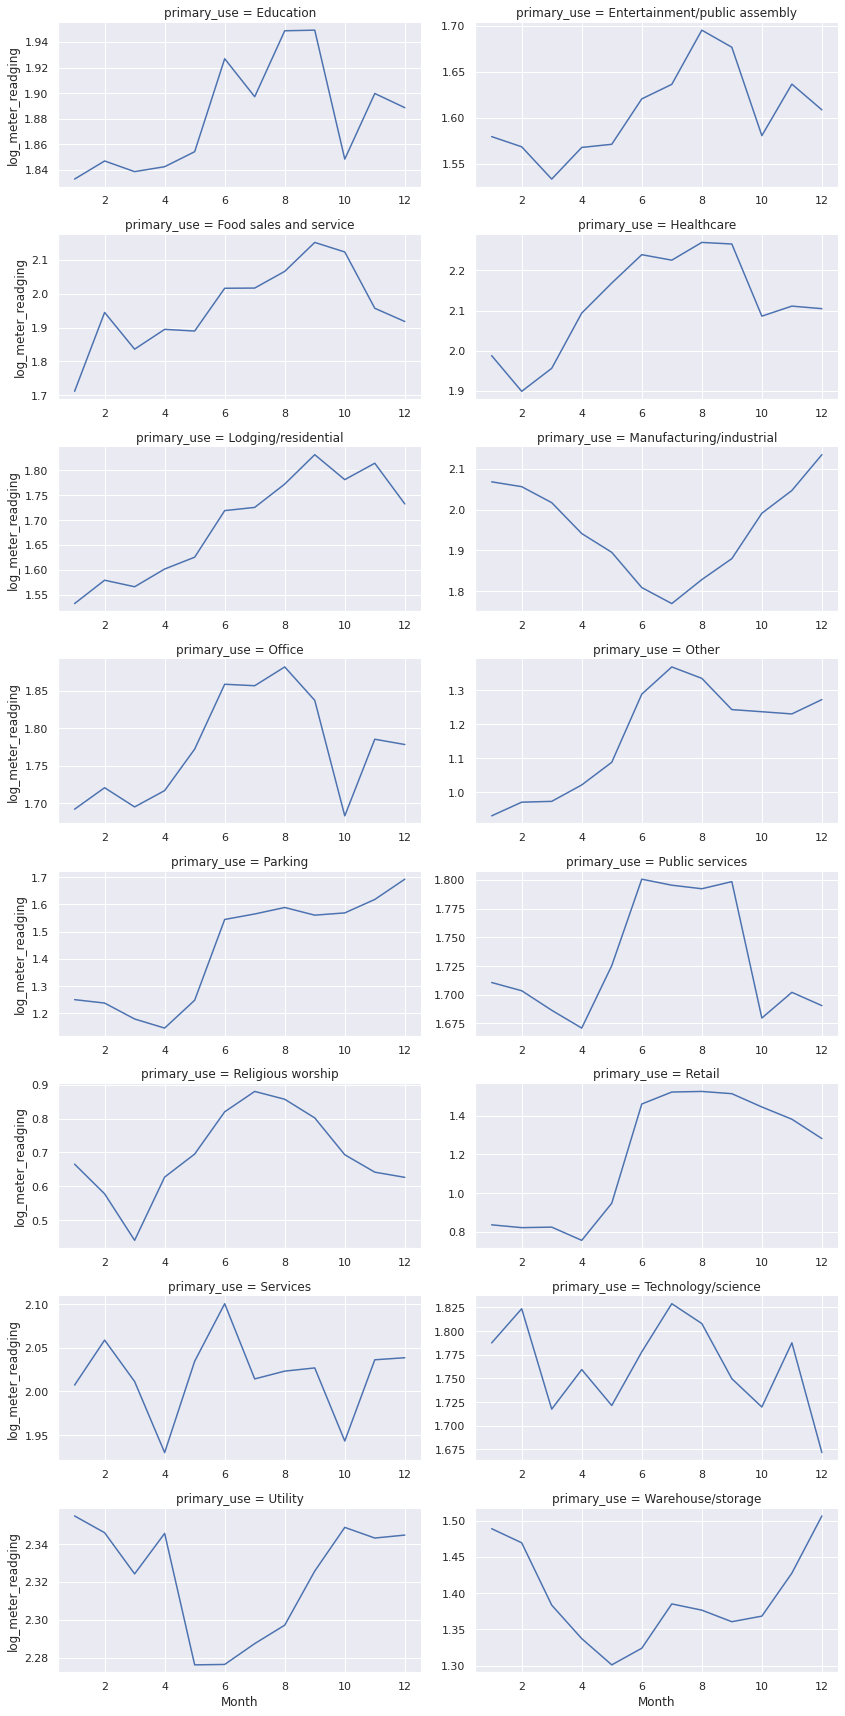

In [ ]:
# Monthly Avergare Energy Consumptions for different Primay use
df_monthly_avg= df_train.groupby(['Month', 'primary_use']).log_meter_readging.mean().reset_index()
p= sns.FacetGrid(df_monthly_avg, col='primary_use',col_wrap=2, height=3, aspect=2,sharey=False, sharex=False, palette="bright", legend_out=True)
p.map(sns.lineplot,'Month', 'log_meter_readging')
plt.show()

In the above figure, we have plotted the average hourly usage for differnt o primary usage category.

* The educational institutes usage is minimum in the initial months of the year  while have the peak usage in August and September. The .
* Entertainment peak is in August
* Food Sale Peak in Sep
* Heathcare pea in Aug and Spetember
* Residential peak in Sep
* Manufacturing minimum in July
* Office Peak in Summer
* Parking Peak in Decmeber while minimum in April
* Public Service Peak in June
* Religious worship peak in July
* Retail peak from June to October


Text(0.5, 1.0, 'Correlation Matrix')

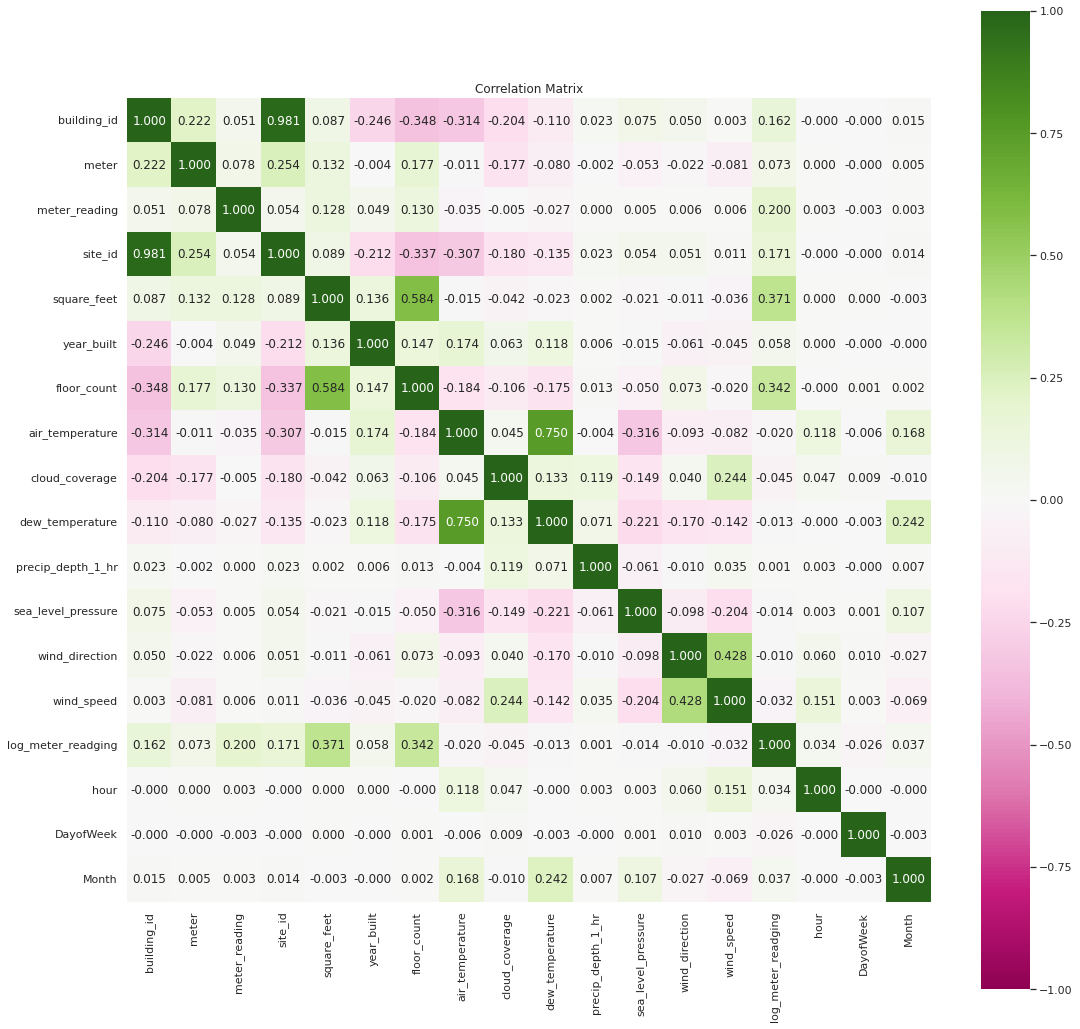

In [ ]:
#correlation matrix
plt.figure(figsize=(18,18))
sns.heatmap(df_train.corr(), annot=True, fmt='.3f', vmin=-1, vmax=1, center=0, square=True, cmap='PiYG') # fmt is for 3 decimal place
plt.title('Correlation Matrix')

We have plotted the correlation matrix of the features available. The square feet and floor count features have a strong positive correlation with the log of meter reading which is modified target variable.  Further building ID and Site ID also shows a significant positive correlation with log of meter reading indicating that building at some specific location consumes relatively higher energy in comparison to other.  A negative correlation with cloud coverage and air temperature is also observed. 

# Modeling and Error Analysis

## Droping zero meter reading

In [ ]:
df_train.drop(df_train[df_train["meter_reading"]== 0.0].index, inplace= True) # dropping zero reading as this doesnot make sense in realworld and not useful in our analysis

## Missing Values


In [ ]:
df_train.isnull().sum() # Missing value in Training data

building_id                135
meter                      135
timestamp                    0
meter_reading              135
site_id                      0
primary_use                135
square_feet                135
year_built            11016480
floor_count           15071361
air_temperature          89444
cloud_coverage         7967220
dew_temperature          92539
precip_depth_1_hr      3521959
sea_level_pressure     1187577
wind_direction         1325701
wind_speed              132573
log_meter_readging         135
hour                         0
DayofWeek                    0
Month                        0
dtype: int64

In [ ]:
df_train.isnull().sum()*100/len(df_train) # Percentage missing value in train data

building_id            0.000737
meter                  0.000737
timestamp              0.000000
meter_reading          0.000737
site_id                0.000000
primary_use            0.000737
square_feet            0.000737
year_built            60.118224
floor_count           82.246186
air_temperature        0.488106
cloud_coverage        43.478054
dew_temperature        0.504996
precip_depth_1_hr     19.219744
sea_level_pressure     6.480747
wind_direction         7.234506
wind_speed             0.723466
log_meter_readging     0.000737
hour                   0.000000
DayofWeek              0.000000
Month                  0.000000
dtype: float64


We can see that top three missing values are floor_count(82.6%), year_bulit (56%) and cloud_coverage (43.6%) 

However, floor_count have second largest correlation cofficent with target variable which is log of energy meter reading.

Highest being square_feet area, in the correlation matrix we can check that the correation coffiecent between square_feet and floor_count is 0.54. Even when many around 83 % of floor count data is missing so we can drop this floor_count variable. Because firstly many data are missing and second it is an redundent feature. 


Other two features which has high missing values are year_built and cloud_coverage. we are dropping the year_built as it dont have high correlation coffiecent with target variable also we dont have any speicific metric to impute this.

We are not dropping cloud cover because with the help of site_id and hour of the day we can impute relatively easily.

### Droping year built and floor_count

In [ ]:
df_train.drop(['year_built', 'floor_count'], axis=1,inplace=True) # Droping year built and floor_count

### Dropping Null meter reading

In [ ]:
df_train.drop(df_train[df_train["meter_reading"].isnull()].index, inplace= True)

### Imputing Missing data

In [ ]:
# Feature               Missing Values
# air_temperature        0.478517
# cloud_coverage        43.650614
# dew_temperature        0.495755
# precip_depth_1_hr     18.561099
# sea_level_pressure     6.096575
# wind_direction         7.171844
# wind_speed             0.711294

#cloud coverage
df_cloud_coverage=df_train.groupby(['site_id','hour'])['cloud_coverage'].transform('median')
df_train['cloud_coverage'].fillna(df_cloud_coverage,inplace=True)

# precip_depth_1_hr 
df_precip_depth_1_hr =df_train.groupby(['site_id','hour'])['precip_depth_1_hr'].transform('median')
df_train['precip_depth_1_hr'].fillna(df_precip_depth_1_hr, inplace=True)

# sea_level_pressure 
df_sea_level_pressure =df_train.groupby(['site_id','hour'])['sea_level_pressure'].transform('median')
df_train['sea_level_pressure'].fillna(df_sea_level_pressure, inplace=True)

# wind_direction 
df_wind_direction =df_train.groupby(['site_id','hour'])['wind_direction'].transform('median')
df_train['wind_direction'].fillna(df_wind_direction, inplace=True)

# wind_speed 
df_wind_speed =df_train.groupby(['site_id','hour'])['wind_speed'].transform('median')
df_train['wind_speed'].fillna(df_wind_speed, inplace=True)

# dew_temperature 
df_dew_temperature =df_train.groupby(['site_id','hour'])['dew_temperature'].transform('median')
df_train['dew_temperature'].fillna(df_dew_temperature, inplace=True)

# air_temperature
df_air_temperature=df_train.groupby(['site_id', 'hour'])['air_temperature'].transform('median')
df_train['air_temperature'].fillna(df_air_temperature, inplace=True)




In [ ]:
df_train.isnull().sum()*100/len(df_train) # percentage of missing values after missing values 

building_id           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
air_temperature       0.000000
cloud_coverage        2.026243
dew_temperature       0.000000
precip_depth_1_hr     8.744587
sea_level_pressure    4.222492
wind_direction        0.000000
wind_speed            0.000000
log_meter_readging    0.000000
hour                  0.000000
DayofWeek             0.000000
Month                 0.000000
dtype: float64

Now the missing values are much lesser and can only be seen in
we will impute this with median of feature

*   cloud_coverage
*   precip_depth_1_hr   

*   sea_level_pressure

we will impute this with median of feature






In [ ]:
df_train['cloud_coverage'].fillna(df_train['cloud_coverage'].median(), inplace=True)
df_train['sea_level_pressure'].fillna(df_train['sea_level_pressure'].median(), inplace=True)
df_train['precip_depth_1_hr'].fillna(df_train['precip_depth_1_hr'].median(), inplace=True)

Now our training data is clean, we can go ahead with feature agumentation

## Adding new *features*

### Holiday Information





No specific information about about the location are provided so it becomes ***difficult to use Holiday package***  so we are restricting to weekend and weekday feature created by utlizing day of the week

In [ ]:
df_train["Weekend"] = df_train["DayofWeek"] > 4

### Working hour feature

As energy consumption during the working hour is expected to be different from during the non working hour so a new feature considering 6 AM to 8 PM as working hour is created. This time period of 6 AM to 8 PM is considered based on visual analysis of energy consumption by different primary use

In [ ]:
df_train['WorkingHour']= df_train['timestamp'].apply(lambda x: 1 if x.hour >=6 and x.hour <=20 else 0)

### Relative Humity Feature

https://www.nature.com/articles/s41467-020-15393-8

The above article  show that in many of the high energy consuming states, such as California and Texas, projections based on air temperature alone underestimates cooling demand by as much as 10–15% under both present and future climate scenarios. Our results establish that air temperature is a necessary but not sufficient variable for adequately characterizing the climate sensitivity of cooling load, and that **near-surface humidity** plays an equally important role.

Thus a new feature called relative humity is created

` RH: =100*(EXP((17.625*TD)/(243.04+TD))/EXP((17.625*T)/(243.04+T)))`

Temperature T (°) 
Dewpoint Td (°) 
Relative Humidity RH (%) 

Temperature T (°) and 
Dewpoint Td (°) inputs/outputs to the equations are in 

Source :- https://bmcnoldy.rsmas.miami.edu/Humidity.html 
 
     

In [ ]:
df_train['relative_humidity']= 100*((np.exp((17.625*df_train['dew_temperature'])/
                                            (243.04+df_train['dew_temperature'])))/(np.exp((17.625*df_train['air_temperature'])/
                                                                                          (243.04+df_train['air_temperature']))))

In [ ]:
df_train["Weekend"]

45          False
72          False
91          False
123         False
148         False
            ...  
20216095    False
20216096    False
20216097    False
20216098    False
20216099    False
Name: Weekend, Length: 18324558, dtype: bool

## Modeling

### Importing requisite Library for modeling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import math
import pickle
import joblib
from tqdm import tqdm
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
import lightgbm as lgb

### Base Line Model

For baseline model, we will use the site_id and primary use to find the mean readings for each combination

In [ ]:
#baseline model based on mean
df_y_pred = df_train.groupby(['site_id', 'primary_use'])['log_meter_readging'].mean().reset_index()

### Test Train Split

We are going to do test train split based on time since for cross validation as for in future we are going to have data for upcoming period only, **thus K-Fold cross validation is not used ***

In [ ]:
df_train=df_train.sort_values(by='timestamp') # sorting data by time

In [ ]:
X_train, X_CV= train_test_split(df_train, test_size=0.20, shuffle=False) # Keeping 20 % data of later time for CV

In [ ]:
#y_pred for baseline
df_y_pred.rename(columns={"log_meter_readging": "y_pred_base"}, inplace=True) # Changing name of base prediction value
X_train= X_train.merge(df_y_pred, on=['site_id', 'primary_use'], how='left') 
X_CV= X_CV.merge(df_y_pred,on=['site_id', 'primary_use'], how='left')

In [ ]:
#RMSE score for baseline model
rmse_base_tr=math.sqrt(mean_squared_error(X_train['log_meter_readging'], X_train['y_pred_base']))
rmse_base_cv=math.sqrt(mean_squared_error(X_CV['log_meter_readging'], X_CV['y_pred_base']))
print("RMSE for baseline model for train data:", rmse_base_tr)
print("RMSE for baseline model for cv data:", rmse_base_cv)

RMSE for baseline model for train data: 0.6517340248138466
RMSE for baseline model for cv data: 0.6650146474535229


### Reducing Memory use 

In [ ]:
#https://www.kaggle.com/kernels/scriptcontent/3684066/download

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    #iterating over every column and finding the type of the column
    for col in df.columns:
      if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
      col_type = df[col].dtype
        
        #If the columns is not object
      if col_type != object:
          #Get the minimum and maximum value
            c_min = df[col].min()
            c_max = df[col].max()
            #If the type is int
            if str(col_type)[:3] == 'int':
              #If the min max values lies with thin the range of int8 type then assign the type as int8
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
              #If the min max values lies with thin the range of int16 type then assign the type as int16 
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
              #If the min max values lies with thin the range of int32 type then assign the type as int32
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
              #If the min max values lies with thin the range of int64 type then assign the type as int64
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
              #If the min max values lies with thin the range of float16 type then assign the type as float16
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
              #If the min max values lies with thin the range of float32 type then assign the type as float32
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
      else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Label Binarization

In [ ]:
X_train['primary_use'].unique()

array(['Retail', 'Office', 'Education', 'Entertainment/public assembly',
       'Warehouse/storage', 'Services', 'Lodging/residential', 'Parking',
       'Public services', 'Healthcare', 'Manufacturing/industrial',
       'Other', 'Technology/science', 'Food sales and service', 'Utility',
       'Religious worship'], dtype=object)

In [ ]:
X_train = pd.concat([X_train, pd.get_dummies(X_train.primary_use)], axis=1).drop(['primary_use'], axis=1)
X_CV = pd.concat([X_CV, pd.get_dummies(X_CV.primary_use)], axis=1).drop(['primary_use'], axis=1)

In [ ]:
X_CV.describe

<bound method NDFrame.describe of          building_id  meter  ... Utility  Warehouse/storage
0              171.0    0.0  ...       0                  0
1              171.0    1.0  ...       0                  0
2              172.0    0.0  ...       0                  0
3              172.0    1.0  ...       0                  0
4              173.0    0.0  ...       0                  0
...              ...    ...  ...     ...                ...
3664907       1344.0    2.0  ...       0                  0
3664908       1345.0    1.0  ...       0                  0
3664909       1345.0    2.0  ...       0                  0
3664910       1339.0    0.0  ...       0                  0
3664911       1067.0    0.0  ...       0                  0

[3664912 rows x 37 columns]>

### Creating Files for training

In [ ]:
y_readings_tr=X_train['log_meter_readging']
y_readings_cv=X_CV['log_meter_readging']
X_train.drop(['log_meter_readging', 'y_pred_base','meter_reading'], axis=1, inplace=True) # meter reading our original value on which log is taken is also need to be dropped
X_CV.drop(['log_meter_readging', 'y_pred_base','meter_reading'], axis=1, inplace=True) # meter reading our original value on which log is taken is also need to be dropped

### Dropping redundent features

In [ ]:
X_train.drop(['site_id', 'dew_temperature','timestamp'],axis=1,inplace=True)
X_CV.drop(['site_id', 'dew_temperature','timestamp'],axis=1,inplace=True)

### Reducing memeory use

In [ ]:
X_train=reduce_mem_usage(X_train)
X_CV=reduce_mem_usage(X_CV)

Memory usage of dataframe is 1915.33 MB
Memory usage after optimization is: 950.68 MB
Decreased by 50.4%
Memory usage of dataframe is 478.83 MB
Memory usage after optimization is: 237.67 MB
Decreased by 50.4%


### Testing different Model

#### Decision Tree Regressor

In [ ]:
cv_error_array=[]
depth=[3,5,7,9,11,15]
for i in depth:
  d_reg=DecisionTreeRegressor(max_depth=i,random_state=0)
  d_reg.fit(X_train,y_readings_tr)
  pred_d_reg=d_reg.predict(X_CV)
  cv_error_array.append(math.sqrt(mean_squared_error(y_readings_cv, pred_d_reg)))
  print("rmse for max_depth:", i,'is',math.sqrt(mean_squared_error(y_readings_cv, pred_d_reg)))

rmse for max_depth: 3 is 0.6055028477208114
rmse for max_depth: 5 is 0.5685886837750483
rmse for max_depth: 7 is 0.5056059816760242
rmse for max_depth: 9 is 0.45518772146667347
rmse for max_depth: 11 is 0.4122755858716501
rmse for max_depth: 15 is 0.3685778072364839


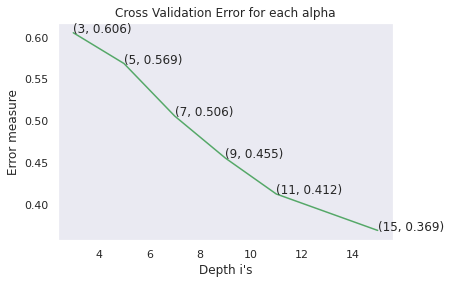

In [ ]:
best_alpha = np.argmin(cv_error_array)
fig, ax = plt.subplots()
ax.plot(depth, cv_error_array,c='g')
for i, txt in enumerate(np.round(cv_error_array,3)):
  ax.annotate((depth[i],np.round(txt,3)), (depth[i],cv_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Depth i's")
plt.ylabel("Error measure")
plt.show()

In [ ]:
d_reg=DecisionTreeRegressor(max_depth=depth[best_alpha],random_state=5)
d_reg.fit(X_train,y_readings_tr)
pred_d_reg_tr=d_reg.predict(X_train)
pred_d_reg_cv=d_reg.predict(X_CV)
print("Train log_rmse for max_depth:", depth[best_alpha],'is',math.sqrt(mean_squared_error(y_readings_tr, pred_d_reg_tr)))
print("CV log_rmse for max_depth:", depth[best_alpha],'is',math.sqrt(mean_squared_error(y_readings_cv, pred_d_reg_cv)))

Train log_rmse for max_depth: 15 is 0.27233059458224745
CV log_rmse for max_depth: 15 is 0.36779619274186626


In [ ]:
#Save the models to a pickle file for making predictions on test data in future
filename_reg='decision_tree_reg.sav'
joblib.dump(d_reg,filename_reg)

['decision_tree_reg.sav']

#### LGBM Regressor

In [ ]:
import lightgbm as lgb
lgb_estimators=[75,100,300,1000,2000]
cv_error_array=[]
for i in lgb_estimators:
    lgb_reg=lgb.LGBMRegressor(boosting_type='gbdt', n_estimators=i,objective='rmse', n_jobs=-1)
    lgb_reg.fit(X_train,y_readings_tr)
    pred_reg_lgb=lgb_reg.predict(X_CV)
    cv_error_array.append(math.sqrt(mean_squared_error(y_readings_cv, pred_reg_lgb)))
    print("rmse for estimators:", i,'is',math.sqrt(mean_squared_error(y_readings_cv, pred_reg_lgb)))

rmse for estimators: 75 is 0.403587226467568
rmse for estimators: 100 is 0.3909886886629944
rmse for estimators: 300 is 0.3360202922733504
rmse for estimators: 1000 is 0.2907440494395471
rmse for estimators: 2000 is 0.27679021363883205


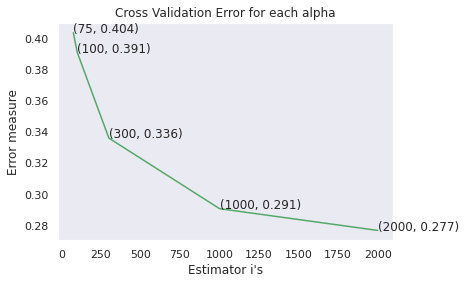

In [ ]:
best_alpha = np.argmin(cv_error_array)
fig, ax = plt.subplots()
ax.plot(lgb_estimators, cv_error_array,c='g')
for i, txt in enumerate(np.round(cv_error_array,3)):
  ax.annotate((lgb_estimators[i],np.round(txt,3)), (lgb_estimators[i],cv_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Estimator i's")
plt.ylabel("Error measure")
plt.show()

In [ ]:
lgb_reg=lgb.LGBMRegressor(boosting_type='gbdt', n_estimators=lgb_estimators[best_alpha], objective='rmse',n_jobs=-1)
lgb_reg.fit(X_train,y_readings_tr)
pred_reg_lgb_cv=lgb_reg.predict(X_CV)
pred_reg_lgb_tr=lgb_reg.predict(X_train)
print("Train rmse for estimators:", lgb_estimators[best_alpha],'is',math.sqrt(mean_squared_error(y_readings_tr, pred_reg_lgb_tr)))
print("CV rmse for estimators:", lgb_estimators[best_alpha],'is',math.sqrt(mean_squared_error(y_readings_cv, pred_reg_lgb_cv)))

Train rmse for estimators: 2000 is 0.1981667419682844
CV rmse for estimators: 2000 is 0.2767902136388323


In [ ]:
filename_reg='lgb_reg.sav'
joblib.dump(lgb_reg,filename_reg)

['lgb_reg.sav']

#### LGBM Random Forest Regressor

In [ ]:
lgb_estimators=[75,100,300,1000,2000]
cv_error_array=[]
for i in lgb_estimators:
    rf_reg=lgb.LGBMRegressor(boosting_type='rf', n_estimators=i, n_jobs=-1,objective='rmse',subsample=0.8,feature_fraction=0.8,bagging_freq=1)
    rf_reg.fit(X_train,y_readings_tr)
    pred_rf_reg=rf_reg.predict(X_CV)
    cv_error_array.append(math.sqrt(mean_squared_error(y_readings_cv, pred_rf_reg)))
    print("rmse for estimators:", i,'is',math.sqrt(mean_squared_error(y_readings_cv, pred_rf_reg)))

rmse for estimators: 75 is 0.5302361031564296
rmse for estimators: 100 is 0.5331941969455183
rmse for estimators: 300 is 0.5315639982286595
rmse for estimators: 1000 is 0.5299600865357538
rmse for estimators: 2000 is 0.530093626031451


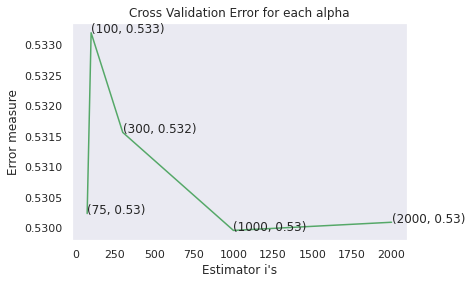

In [ ]:
best_alpha = np.argmin(cv_error_array)
fig, ax = plt.subplots()
ax.plot(lgb_estimators, cv_error_array,c='g')
for i, txt in enumerate(np.round(cv_error_array,3)):
  ax.annotate((lgb_estimators[i],np.round(txt,3)), (lgb_estimators[i],cv_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Estimator i's")
plt.ylabel("Error measure")
plt.show()

In [ ]:
rf_reg=lgb.LGBMRegressor(boosting_type='rf', n_estimators=lgb_estimators[best_alpha], n_jobs=-1,objective='rmse',subsample=0.8,feature_fraction=0.8,bagging_freq=1)
rf_reg.fit(X_train,y_readings_tr)
pred_reg_lgb_cv=rf_reg.predict(X_CV)
pred_reg_lgb_tr=rf_reg.predict(X_train)
print("Train rmse for estimators:", lgb_estimators[best_alpha],'is',math.sqrt(mean_squared_error(y_readings_tr, pred_reg_lgb_tr)))
print("CV rmse for estimators:", lgb_estimators[best_alpha],'is',math.sqrt(mean_squared_error(y_readings_cv, pred_reg_lgb_cv)))

Train rmse for estimators: 1000 is 0.5138971598862808
CV rmse for estimators: 1000 is 0.5312307391600198


In [ ]:
#Save the models to a pickle file for making predictions on test data in future
filename_reg='rf_reg.sav'
joblib.dump(rf_reg,filename_reg)

['rf_reg.sav']

# Testing advance models 


## Cat Boost

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 1.1 MB/s 


In [ ]:
import catboost as cb
cb_estimators=[1000,1500]
cv_error_array=[]
for i in cb_estimators:
    cb_reg=cb.CatBoostRegressor(n_estimators=i)
    cb_reg.fit(X_train,y_readings_tr)
    pred_reg_cb=cb_reg.predict(X_CV)
    cv_error_array.append(math.sqrt(mean_squared_error(y_readings_cv, pred_reg_cb)))
    print("rmse for estimators:", i,'is',math.sqrt(mean_squared_error(y_readings_cv, pred_reg_cb)))

Learning rate set to 0.186392
0:	learn: 0.6970483	total: 497ms	remaining: 8m 16s
1:	learn: 0.6549960	total: 810ms	remaining: 6m 44s
2:	learn: 0.6239366	total: 1.18s	remaining: 6m 32s
3:	learn: 0.6003200	total: 1.5s	remaining: 6m 14s
4:	learn: 0.5763026	total: 1.82s	remaining: 6m 2s
5:	learn: 0.5618358	total: 2.09s	remaining: 5m 45s
6:	learn: 0.5517263	total: 2.34s	remaining: 5m 32s
7:	learn: 0.5414786	total: 2.61s	remaining: 5m 23s
8:	learn: 0.5337815	total: 2.86s	remaining: 5m 15s
9:	learn: 0.5281113	total: 3.16s	remaining: 5m 13s
10:	learn: 0.5194854	total: 3.44s	remaining: 5m 9s
11:	learn: 0.5130970	total: 3.7s	remaining: 5m 4s
12:	learn: 0.5098123	total: 3.96s	remaining: 5m
13:	learn: 0.5066748	total: 4.23s	remaining: 4m 57s
14:	learn: 0.4995199	total: 4.53s	remaining: 4m 57s
15:	learn: 0.4961374	total: 4.79s	remaining: 4m 54s
16:	learn: 0.4917043	total: 5.04s	remaining: 4m 51s
17:	learn: 0.4897457	total: 5.3s	remaining: 4m 49s
18:	learn: 0.4852746	total: 5.59s	remaining: 4m 48s
19

In [ ]:
print("Rmse for estimators: 1000 is 0.2994")
print("Rmse for estimators: 1500 is 0.2997")

Rmse for estimators: 1000 is 0.2994
Rmse for estimators: 1500 is 0.2997


In [ ]:
filename_cfl='CatBoost_reg.sav'
joblib.dump(cb_reg,filename_cfl)

['CatBoost_reg.sav']

## Deep Learning model

In [ ]:
from keras.models import Model, load_model
from keras.layers import Input, Dropout, Dense, Embedding, SpatialDropout1D, concatenate, BatchNormalization, Flatten
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
from keras import backend as K
from keras.models import Model
from tensorflow.keras.metrics import RootMeanSquaredError
from keras import optimizers
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, Embedding
import keras.backend as K

In [ ]:
#https://stackoverflow.com/questions/43855162/rmse-rmsle-loss-function-in-keras
# As root mean square error is not directl available in Keras
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

## MLP

In [ ]:
inp_dim=X_train.shape[1]
beta=[128,256,512,1024,2048]
earlystop= EarlyStopping(monitor='val_loss', mode='min', patience=3)
for i in tqdm(beta):

  model=Sequential()
  model.add(Dense(i, activation='relu', input_shape=(inp_dim,)))
  model.add(Dense(i*0.75, activation='relu'))
  model.add(Dense(i*0.5, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(16, activation='linear'))
  opt=Adam(0.0001)
  model.compile(optimizer=opt, loss= root_mean_squared_error)
  model.fit(X_train, y_readings_tr,epochs=15,batch_size=2048,validation_data=(X_CV,y_readings_cv),callbacks=earlystop)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/15
7159/7159 [==============================] - 26s 3ms/step - loss: 14.7593 - val_loss: 1.4472
Epoch 2/15
7159/7159 [==============================] - 23s 3ms/step - loss: 1.1913 - val_loss: 0.9380
Epoch 3/15
7159/7159 [==============================] - 22s 3ms/step - loss: 0.8193 - val_loss: 0.7668
Epoch 4/15
7159/7159 [==============================] - 22s 3ms/step - loss: 0.7576 - val_loss: 0.7672
Epoch 5/15
7159/7159 [==============================] - 22s 3ms/step - loss: 0.7575 - val_loss: 0.7672
Epoch 6/15
7159/7159 [==============================] - 22s 3ms/step - loss: 0.7575 - val_loss: 0.7673


 20%|██        | 1/5 [02:21<09:26, 141.74s/it]

Epoch 1/15
7159/7159 [==============================] - 24s 3ms/step - loss: 15.4308 - val_loss: 1.4491
Epoch 2/15
7159/7159 [==============================] - 23s 3ms/step - loss: 1.1929 - val_loss: 0.9392
Epoch 3/15
7159/7159 [==============================] - 23s 3ms/step - loss: 0.8199 - val_loss: 0.7668
Epoch 4/15
7159/7159 [==============================] - 23s 3ms/step - loss: 0.7576 - val_loss: 0.7673
Epoch 5/15
7159/7159 [==============================] - 23s 3ms/step - loss: 0.7575 - val_loss: 0.7672
Epoch 6/15
7159/7159 [==============================] - 23s 3ms/step - loss: 0.7575 - val_loss: 0.7672


 40%|████      | 2/5 [04:44<07:06, 142.08s/it]

Epoch 1/15
7159/7159 [==============================] - 28s 4ms/step - loss: 5.0913 - val_loss: 1.4499
Epoch 2/15
7159/7159 [==============================] - 25s 4ms/step - loss: 1.1936 - val_loss: 0.9397
Epoch 3/15
7159/7159 [==============================] - 26s 4ms/step - loss: 0.8201 - val_loss: 0.7668
Epoch 4/15
7159/7159 [==============================] - 25s 4ms/step - loss: 0.7576 - val_loss: 0.7672
Epoch 5/15
7159/7159 [==============================] - 25s 4ms/step - loss: 0.7575 - val_loss: 0.7672
Epoch 6/15
7159/7159 [==============================] - 25s 4ms/step - loss: 0.7575 - val_loss: 0.7672


 60%|██████    | 3/5 [07:23<04:59, 149.89s/it]

Epoch 1/15
7159/7159 [==============================] - 42s 6ms/step - loss: 2.7883 - val_loss: 1.4485
Epoch 2/15
7159/7159 [==============================] - 39s 5ms/step - loss: 1.1924 - val_loss: 0.9388
Epoch 3/15
7159/7159 [==============================] - 39s 5ms/step - loss: 0.8197 - val_loss: 0.7668
Epoch 4/15
7159/7159 [==============================] - 39s 5ms/step - loss: 0.7576 - val_loss: 0.7673
Epoch 5/15
7159/7159 [==============================] - 39s 5ms/step - loss: 0.7575 - val_loss: 0.7672
Epoch 6/15
7159/7159 [==============================] - 39s 5ms/step - loss: 0.7575 - val_loss: 0.7672


 80%|████████  | 4/5 [11:23<03:05, 185.67s/it]

Epoch 1/15
7159/7159 [==============================] - 93s 13ms/step - loss: 2.5625 - val_loss: 1.4485
Epoch 2/15
7159/7159 [==============================] - 90s 13ms/step - loss: 1.1924 - val_loss: 0.9388
Epoch 3/15
7159/7159 [==============================] - 90s 13ms/step - loss: 0.8197 - val_loss: 0.7668
Epoch 4/15
7159/7159 [==============================] - 90s 13ms/step - loss: 0.7576 - val_loss: 0.7672
Epoch 5/15
7159/7159 [==============================] - 90s 13ms/step - loss: 0.7575 - val_loss: 0.7672
Epoch 6/15
7159/7159 [==============================] - 90s 13ms/step - loss: 0.7575 - val_loss: 0.7672


100%|██████████| 5/5 [20:32<00:00, 246.45s/it]


In [ ]:

inp_dim=X_train.shape[1]
model=Sequential()
model.add(Dense(2048, activation='relu', input_shape=(inp_dim,)))
model.add(Dense(1536, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='linear'))
opt=Adam(0.0001)
model.compile(optimizer=opt, loss= root_mean_squared_error)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              65536     
                                                                 
 dense_1 (Dense)             (None, 1536)              3147264   
                                                                 
 dense_2 (Dense)             (None, 1024)              1573888   
                                                                 
 dense_3 (Dense)             (None, 32)                32800     
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
Total params: 4,820,016
Trainable params: 4,820,016
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
inp_dim=X_train.shape[1]
earlystop= EarlyStopping(monitor='val_loss', mode='min', patience=3)

model=Sequential()
model.add(Dense(2048, activation='relu', input_shape=(inp_dim,)))
model.add(Dense(1536, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='linear'))
opt=Adam(0.0001)
model.compile(optimizer=opt, loss= root_mean_squared_error)
model.fit(X_train, y_readings_tr,epochs=15,batch_size=2048,validation_data=(X_CV,y_readings_cv),callbacks=earlystop)

Epoch 1/15
7159/7159 [==============================] - 94s 13ms/step - loss: 2.2285 - val_loss: 1.4484
Epoch 2/15
7159/7159 [==============================] - 90s 13ms/step - loss: 1.1923 - val_loss: 0.9387
Epoch 3/15
7159/7159 [==============================] - 90s 13ms/step - loss: 0.8197 - val_loss: 0.7668
Epoch 4/15
7159/7159 [==============================] - 90s 13ms/step - loss: 0.7576 - val_loss: 0.7672
Epoch 5/15
7159/7159 [==============================] - 90s 13ms/step - loss: 0.7575 - val_loss: 0.7673
Epoch 6/15
7159/7159 [==============================] - 90s 13ms/step - loss: 0.7575 - val_loss: 0.7673


In [ ]:
print("Rmse for Epoch: 6/15 is 0.7673")

Rmse for Epoch: 6/15 is 0.7673


In [ ]:
#Save the models to a pickle file for making predictions on test data in future
filename_reg='MLP.sav'
joblib.dump(model,filename_reg)

INFO:tensorflow:Assets written to: ram://942107bf-8b18-464a-9ee8-efd70a97ddc2/assets


['MLP.sav']

## Pretty Table

In [ ]:
from prettytable import PrettyTable
summary = PrettyTable()


summary.field_names = ["Model","Best Hyperparameter", "Best RMSE"]
summary.add_row(["Baseline", "Mean", 0.6550])
summary.add_row(["Decision Trees","max_depth = 15", 0.3677])
summary.add_row(["LightGBM GBDT","n_estimators = 2000", 0.2767])
summary.add_row(["Random Forest","n_estimators = 1000", 0.5312])
summary.add_row(["Catboost","n_estimators = 1000", 0.2997])
summary.add_row(["MLP","5 Dense Layer, Relu Activation", 0.7673])
print(summary)

+----------------+--------------------------------+-----------+
|     Model      |      Best Hyperparameter       | Best RMSE |
+----------------+--------------------------------+-----------+
|    Baseline    |              Mean              |   0.655   |
| Decision Trees |         max_depth = 15         |   0.3677  |
| LightGBM GBDT  |      n_estimators = 2000       |   0.2767  |
| Random Forest  |      n_estimators = 1000       |   0.5312  |
|    Catboost    |      n_estimators = 1000       |   0.2997  |
|      MLP       | 5 Dense Layer, Relu Activation |   0.7673  |
+----------------+--------------------------------+-----------+


### Feature Importance

In [ ]:
decision_treee = joblib.load('decision_tree_reg.sav')
LightGBM_GBDT = joblib.load('lgb_reg.sav')
Random_Forest = joblib.load('rf_reg.sav')
Catboost = joblib.load('CatBoost_reg.sav')

#### Decision tree

In [ ]:
importances = decision_treee.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
print(*X_train.columns[sorted_indices], sep = "\n")

square_feet
building_id
meter
air_temperature
Month
Education
Parking
hour
Services
WorkingHour
Entertainment/public assembly
Healthcare
Lodging/residential
Other
Office
Public services
Utility
DayofWeek
Warehouse/storage
Weekend
Manufacturing/industrial
precip_depth_1_hr
Technology/science
relative_humidity
Retail
Food sales and service
sea_level_pressure
cloud_coverage
wind_direction
wind_speed
Religious worship


#### LightGBM_GBDT

In [ ]:
importances = LightGBM_GBDT.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
print(*X_train.columns[sorted_indices], sep = "\n")

building_id
square_feet
meter
Month
air_temperature
hour
DayofWeek
Education
WorkingHour
Office
Entertainment/public assembly
relative_humidity
sea_level_pressure
Lodging/residential
Public services
wind_direction
precip_depth_1_hr
Other
cloud_coverage
wind_speed
Healthcare
Warehouse/storage
Utility
Retail
Services
Parking
Manufacturing/industrial
Technology/science
Food sales and service
Religious worship
Weekend


#### Random_Forest

In [ ]:
importances = Random_Forest.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
print(*X_train.columns[sorted_indices], sep = "\n")

building_id
square_feet
meter
air_temperature
sea_level_pressure
Parking
Other
Services
Education
cloud_coverage
precip_depth_1_hr
Office
Entertainment/public assembly
Month
Utility
Healthcare
relative_humidity
Lodging/residential
Religious worship
Warehouse/storage
Public services
WorkingHour
hour
wind_direction
Manufacturing/industrial
Retail
DayofWeek
wind_speed
Weekend
Food sales and service
Technology/science


#### CatBoost

In [ ]:
importances = Catboost.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
print(*X_train.columns[sorted_indices], sep = "\n")

square_feet
building_id
meter
air_temperature
Education
sea_level_pressure
Office
Month
Entertainment/public assembly
hour
Lodging/residential
cloud_coverage
Parking
Public services
WorkingHour
Other
Healthcare
precip_depth_1_hr
Services
Utility
relative_humidity
Warehouse/storage
Manufacturing/industrial
Weekend
DayofWeek
Technology/science
Retail
Food sales and service
Religious worship
wind_direction
wind_speed


#### Comparison of Feature importance

In [ ]:
feature_importance = PrettyTable()


feature_importance.field_names = ["Model","Feature-1", "Feature-2","Feature-3","Feature-4","Feature-5"]
feature_importance.add_row(["Decision Trees","square_feet","building_id","meter","air_temperature","Month"])
feature_importance.add_row(["LightGBM GBDT","building_id","square_feet","meter","Month","air_temperature"])
feature_importance.add_row(["Random Forest","building_id","square_feet","meter","air_temperature","sea_level_pressure"])
feature_importance.add_row(["Catboost","square_feet","building_id","meter","air_temperature","Education"])
print(feature_importance)

+----------------+-------------+-------------+-----------+-----------------+--------------------+
|     Model      |  Feature-1  |  Feature-2  | Feature-3 |    Feature-4    |     Feature-5      |
+----------------+-------------+-------------+-----------+-----------------+--------------------+
| Decision Trees | square_feet | building_id |   meter   | air_temperature |       Month        |
| LightGBM GBDT  | building_id | square_feet |   meter   |      Month      |  air_temperature   |
| Random Forest  | building_id | square_feet |   meter   | air_temperature | sea_level_pressure |
|    Catboost    | square_feet | building_id |   meter   | air_temperature |     Education      |
+----------------+-------------+-------------+-----------+-----------------+--------------------+


## Prediction 

### Loading and preparing one file

#### Loading and preparing file

In [ ]:
import pandas as pd
import numpy as np
import joblib

In [ ]:
df_data_test = pd.read_csv("test.csv")
df_test_weather = pd.read_csv("weather_test.csv")
df_building_metadata = pd.read_csv("building_metadata.csv")
#
#
df_test = pd.merge(df_data_test,df_building_metadata,how='outer', on ="building_id")
df_test = pd.merge(df_test,df_test_weather,how="outer",on= ["site_id","timestamp"]) # creating one final file with all training data together


In [ ]:
df_test.isnull()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False
1,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False
2,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False
3,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False
4,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41697595,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True
41697596,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True
41697597,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True
41697598,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True


In [ ]:
# Reducing Memory usage
df_test=reduce_mem_usage(df_test)

Memory usage of dataframe is 5408.17 MB
Memory usage after optimization is: 1631.04 MB
Decreased by 69.8%


#### Cleaning test file

In [ ]:
# Covering and adding
df_test["timestamp"] = pd.to_datetime(df_test["timestamp"]) # Converting object type to datetime format for further analysis
df_test["hour"] = df_test["timestamp"].dt.hour # extrating hour from date time and creating new Varibale
df_test["DayofWeek"] = df_test["timestamp"].dt.dayofweek # extrating day of week from date time and creating new Varibale, Monday 0
df_test["Month"] = df_test["timestamp"].dt.month # extrating month from date time and creating new Varibale


In [ ]:
df_test.drop(['year_built', 'floor_count'], axis=1,inplace=True) # Droping year built and floor_count

In [ ]:
df_test.isnull().sum()*100/len(df_test)

row_id                 0.000000
building_id            0.000000
meter                  0.000000
timestamp              0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
air_temperature        0.532167
cloud_coverage        46.866438
dew_temperature        0.625453
precip_depth_1_hr     18.709861
sea_level_pressure     6.035901
wind_direction         7.143488
wind_speed             0.724476
hour                   0.000000
DayofWeek              0.000000
Month                  0.000000
dtype: float64

In [ ]:
# imputing misssing data
#cloud coverage
df_cloud_coverage=df_test.groupby(['site_id','hour'])['cloud_coverage'].transform('median')
df_test['cloud_coverage'].fillna(df_cloud_coverage,inplace=True)

# precip_depth_1_hr 
df_precip_depth_1_hr =df_test.groupby(['site_id','hour'])['precip_depth_1_hr'].transform('median')
df_test['precip_depth_1_hr'].fillna(df_precip_depth_1_hr, inplace=True)

# sea_level_pressure 
df_sea_level_pressure =df_test.groupby(['site_id','hour'])['sea_level_pressure'].transform('median')
df_test['sea_level_pressure'].fillna(df_sea_level_pressure, inplace=True)

# wind_direction 
df_wind_direction =df_test.groupby(['site_id','hour'])['wind_direction'].transform('median')
df_test['wind_direction'].fillna(df_wind_direction, inplace=True)

# wind_speed 
df_wind_speed =df_test.groupby(['site_id','hour'])['wind_speed'].transform('median')
df_test['wind_speed'].fillna(df_wind_speed, inplace=True)

# dew_temperature 
df_dew_temperature =df_test.groupby(['site_id','hour'])['dew_temperature'].transform('median')
df_test['dew_temperature'].fillna(df_dew_temperature, inplace=True)

# air_temperature
df_air_temperature=df_test.groupby(['site_id', 'hour'])['air_temperature'].transform('median')
df_test['air_temperature'].fillna(df_air_temperature, inplace=True)

In [ ]:
df_test['cloud_coverage'].fillna(df_test['cloud_coverage'].median(), inplace=True)
df_test['sea_level_pressure'].fillna(df_test['sea_level_pressure'].median(), inplace=True)
df_test['precip_depth_1_hr'].fillna(df_test['precip_depth_1_hr'].median(), inplace=True)

In [ ]:
# Creating new features
df_test["Weekend"] = df_test["DayofWeek"] > 4
df_test['WorkingHour']= df_test['timestamp'].apply(lambda x: 1 if x.hour >=6 and x.hour <=20 else 0)
df_test['relative_humidity']= 100*((np.exp((17.625*df_test['dew_temperature'])/
                                            (243.04+df_test['dew_temperature'])))/(np.exp((17.625*df_test['air_temperature'])/
                                                                                          (243.04+df_test['air_temperature']))))

In [ ]:
df_test["primary_use"].unique()

['Education', 'Lodging/residential', 'Office', 'Entertainment/public assembly', 'Other', ..., 'Healthcare', 'Utility', 'Technology/science', 'Manufacturing/industrial', 'Services']
Length: 16
Categories (16, object): ['Education', 'Entertainment/public assembly',
                          'Food sales and service', 'Healthcare', ..., 'Services', 'Technology/science',
                          'Utility', 'Warehouse/storage']

In [ ]:
# Binning
df_test = pd.concat([df_test, pd.get_dummies(df_test.primary_use)], axis=1).drop(['primary_use'], axis=1)

In [ ]:
#dropping redundent features
df_test.drop(['site_id', 'dew_temperature','timestamp'],axis=1,inplace=True)

In [ ]:
df_test.shape

(41697600, 32)

In [ ]:
# Reducing Memory usage
df_test=reduce_mem_usage(df_test)

Memory usage of dataframe is 3260.81 MB
Memory usage after optimization is: 2823.38 MB
Decreased by 13.4%


#### prediciting using decision tree

In [ ]:
decision_treee = joblib.load('decision_tree_reg.sav')
predictions=pd.DataFrame()
predictions['row_id']=df_test['row_id']
df_test.drop(['row_id'], axis=1, inplace=True)
predictions['log_meter_reading']= decision_treee.predict(df_test)
predictions['meter_reading']= 10**(predictions['log_meter_reading'])-1# for converting log10(value+1) to original value
predictions.drop(['log_meter_reading'], axis=1,inplace=True)
predictions.to_csv('Decision_tree_predictions.csv', index=False)

#### Predicting using GBDT

In [ ]:
LightGBM_GBDT = joblib.load('lgb_reg.sav')
predictions=pd.DataFrame()
predictions['row_id']=df_test['row_id']
df_test.drop(['row_id'], axis=1, inplace=True)
predictions['log_meter_reading']= LightGBM_GBDT.predict(df_test)
predictions['meter_reading']= 10**(predictions['log_meter_reading'])-1# for converting log10(value+1) to original value
predictions.drop(['log_meter_reading'], axis=1,inplace=True)
predictions.to_csv('LightGBM_GBDT_predictions.csv', index=False)

#### Predicting using CAT Boost

In [ ]:
Catboost = joblib.load('CatBoost_reg.sav')
predictions=pd.DataFrame()
predictions['row_id']=df_test['row_id']
df_test.drop(['row_id'], axis=1, inplace=True)
predictions['log_meter_reading']= Catboost.predict(df_test)
predictions['meter_reading']= 10**(predictions['log_meter_reading'])-1# for converting log10(value+1) to original value
predictions.drop(['log_meter_reading'], axis=1,inplace=True)
predictions.to_csv('Catboost_predictions.csv', index=False)

#### Random Forest

In [ ]:
Random_Forest = joblib.load('rf_reg.sav')
predictions=pd.DataFrame()
predictions['row_id']=df_test['row_id']
df_test.drop(['row_id'], axis=1, inplace=True)
predictions['log_meter_reading']= Random_Forest.predict(df_test)
predictions['meter_reading']= 10**(predictions['log_meter_reading'])-1# for converting log10(value+1) to original value
predictions.drop(['log_meter_reading'], axis=1,inplace=True)
predictions.to_csv('Random_Forest_predictions.csv', index=False)

# Streamlit application

In [ ]:
! pip install streamlit

     |████████████████████████████████| 9.7 MB 5.5 MB/s 
     |████████████████████████████████| 76 kB 4.8 MB/s 
     |████████████████████████████████| 4.3 MB 67.4 MB/s 
     |████████████████████████████████| 164 kB 75.1 MB/s 
     |████████████████████████████████| 180 kB 72.0 MB/s 
     |████████████████████████████████| 111 kB 74.3 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 128 kB 71.5 MB/s 
     |████████████████████████████████| 792 kB 73.7 MB/s 
     |████████████████████████████████| 380 kB 78.6 MB/s 
  Created wheel for blinker: filename=blinker-1.4-py3-none-any.whl size=13478 sha256=ff32c1694c58c7489cdcec7c50a12845b0c244b3732242b2d2802ee0cb692a50
  Stored in directory: /root/.cache/pip/wheels/22/f5/18/df711b66eb25b21325c132757d4314db9ac5e8dabeaf196eab
Successfully built blinker
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      S

In [ ]:
import pandas as pd
import numpy as np
import datetime as datetime
import streamlit as st
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import joblib
import time
import pickle

def main():
    st.title('ASHRAE - Great Energy Predictor III')
    st.markdown('Just Enter the following details and we will **predict metered building energy usage**')
    st.sidebar.title("Prepared as project for Diploma in Artificial Intelligence & Machine Learning at UoH and AAIC")
    st.sidebar.markdown('Submitted by [[Saurav Kumar Sahay]'
                        '(https://www.linkedin.com/in/sahaysaurav/)]')
    st.warning('All * are mandotory to choose, for others if no value is provided default values will be picked')
    df = get_data()
    if st.checkbox('Show data I have entered'):
        st.write(df)
    df1 = preprocess_data(df)
    if st.checkbox('Show Preprocessed data'):
        st.write(df1)
    csv = convert_df(df1)
    st.download_button("Press to Download",csv,"file.csv","text/csv",key='download-csv')
        #df1.to_csv("coverted.csv")
    submit = st.button('Predict Energy Consumption')
    model = joblib.load('decision_tree_reg_modified.sav')
    if submit:
        try:
            with st.spinner('Predicting...'):
                time.sleep(2)
                predictions_log = model.predict(df1)
                predictions = 10**predictions_log-1
                answer = str(round(predictions[0], 2))
                st.info(f"Your **predict metered building energy usage** is **{answer}** Units")
                #st.write(predictions)
        except:
            st.warning("Time value is missing kindly recheck your data")
def get_data():
    building_id = st.slider("* A number between 1-1449", min_value = 1, max_value = 1449)
    meter = st.selectbox("* Meter Type 0: electricity, 1: chilledwater, 2: steam, 3: hotwater",['0', '1', '2', '3'])
    timestamp = st.text_input("* Inter timestamp valid type YYYY-MM-DD HH:MM:SS, eg ' 2017-12-31 01:00:00'")
    site_id = st.slider("A number between 0-15", min_value = 0, max_value = 15)
    primary_use = st.selectbox("Chosse the primary use for building",['Retail', 'Office', 'Education', 'Entertainment/public assembly','Warehouse/storage', 'Services', 'Lodging/residential', 'Parking',
       'Public services', 'Healthcare', 'Manufacturing/industrial','Other', 'Technology/science', 'Food sales and service', 'Utility',
       'Religious worship'])
    square_feet = st.slider("Area in square feets", min_value = 2000, max_value = 100000,step = 100, value = 72700)
    year_built = st.slider("Year in which the building was built", min_value = 1900, max_value = 2020, value = 1970)
    floor_count = st.slider("Number of floors in the building",min_value = 1, max_value = 30, value = 3)
    air_temperature = st.slider("Air temperature in degree celcious", min_value = -30.0, max_value = 50.0, step = 0.5, value = 17.0)
    cloud_coverage = st.slider("Select the cloud coverage", min_value = 0.0, max_value = 10.0, step = 0.5, value = 0.0)
    dew_temperature = st.slider("Dew temperature in degree celcious", min_value = -4.0, max_value = 27.0, step = 0.5, value = 9.0)
    precip_depth_1_hr = st.slider("precipitation depth at one hour ", min_value = -1.0, max_value = 30.0, step = 0.5, value = 0.0)
    sea_level_pressure = st.slider("Sea level pressure in Bar", min_value = 900, max_value = 1070, value = 1015)
    wind_direction = st.slider("Direction of wind in 360 degree", min_value = 0, max_value = 360, value = 180)
    wind_speed = st.slider("Speed of wind in meter per seconds", min_value=0.0, max_value= 30.0, value = 3.1, step = 0.1 )
    x = {"building_id" : [building_id],"meter" : [meter],"timestamp"  : [timestamp],"site_id":[site_id], "primary_use":[primary_use],"square_feet":[square_feet],"year_built":[year_built],
    "floor_count":[floor_count],"air_temperature":[air_temperature],"cloud_coverage"  : [cloud_coverage],"dew_temperature" : [dew_temperature],"precip_depth_1_hr":[precip_depth_1_hr],
    "sea_level_pressure":[sea_level_pressure],"wind_direction":[wind_direction],"wind_speed":[wind_speed]}        
    df = pd.DataFrame.from_dict(x)  
    return df
def preprocess_data(df):
    df["timestamp"] = pd.to_datetime(df["timestamp"]) # Converting object type to datetime format for further analysis
    df["hour"] = df["timestamp"].dt.hour # extrating hour from date time and creating new Varibale
    df["DayofWeek"] = df["timestamp"].dt.dayofweek # extrating day of week from date time and creating new Varibale, Monday 0
    df["Month"] = df["timestamp"].dt.month # extrating month from date time and creating new Varibale
    # Creating new features
    df["Weekend"] = df["DayofWeek"] > 4
    df['WorkingHour']= df['timestamp'].apply(lambda x: 1 if x.hour >=6 and x.hour <=20 else 0)
    df['relative_humidity']= 100*((np.exp((17.625*df['dew_temperature'])/
                                            (243.04+df['dew_temperature'])))/(np.exp((17.625*df['air_temperature'])/
                                                                                          (243.04+df['air_temperature']))))
    df.drop(['year_built', 'floor_count','site_id', 'dew_temperature','timestamp',"primary_use"], axis=1,inplace=True) # Droping year built and floor_count
    return df
def convert_df(df):
   return df.to_csv().encode('utf-8')

   
if __name__ == '__main__':
    main()
    


## Application interface

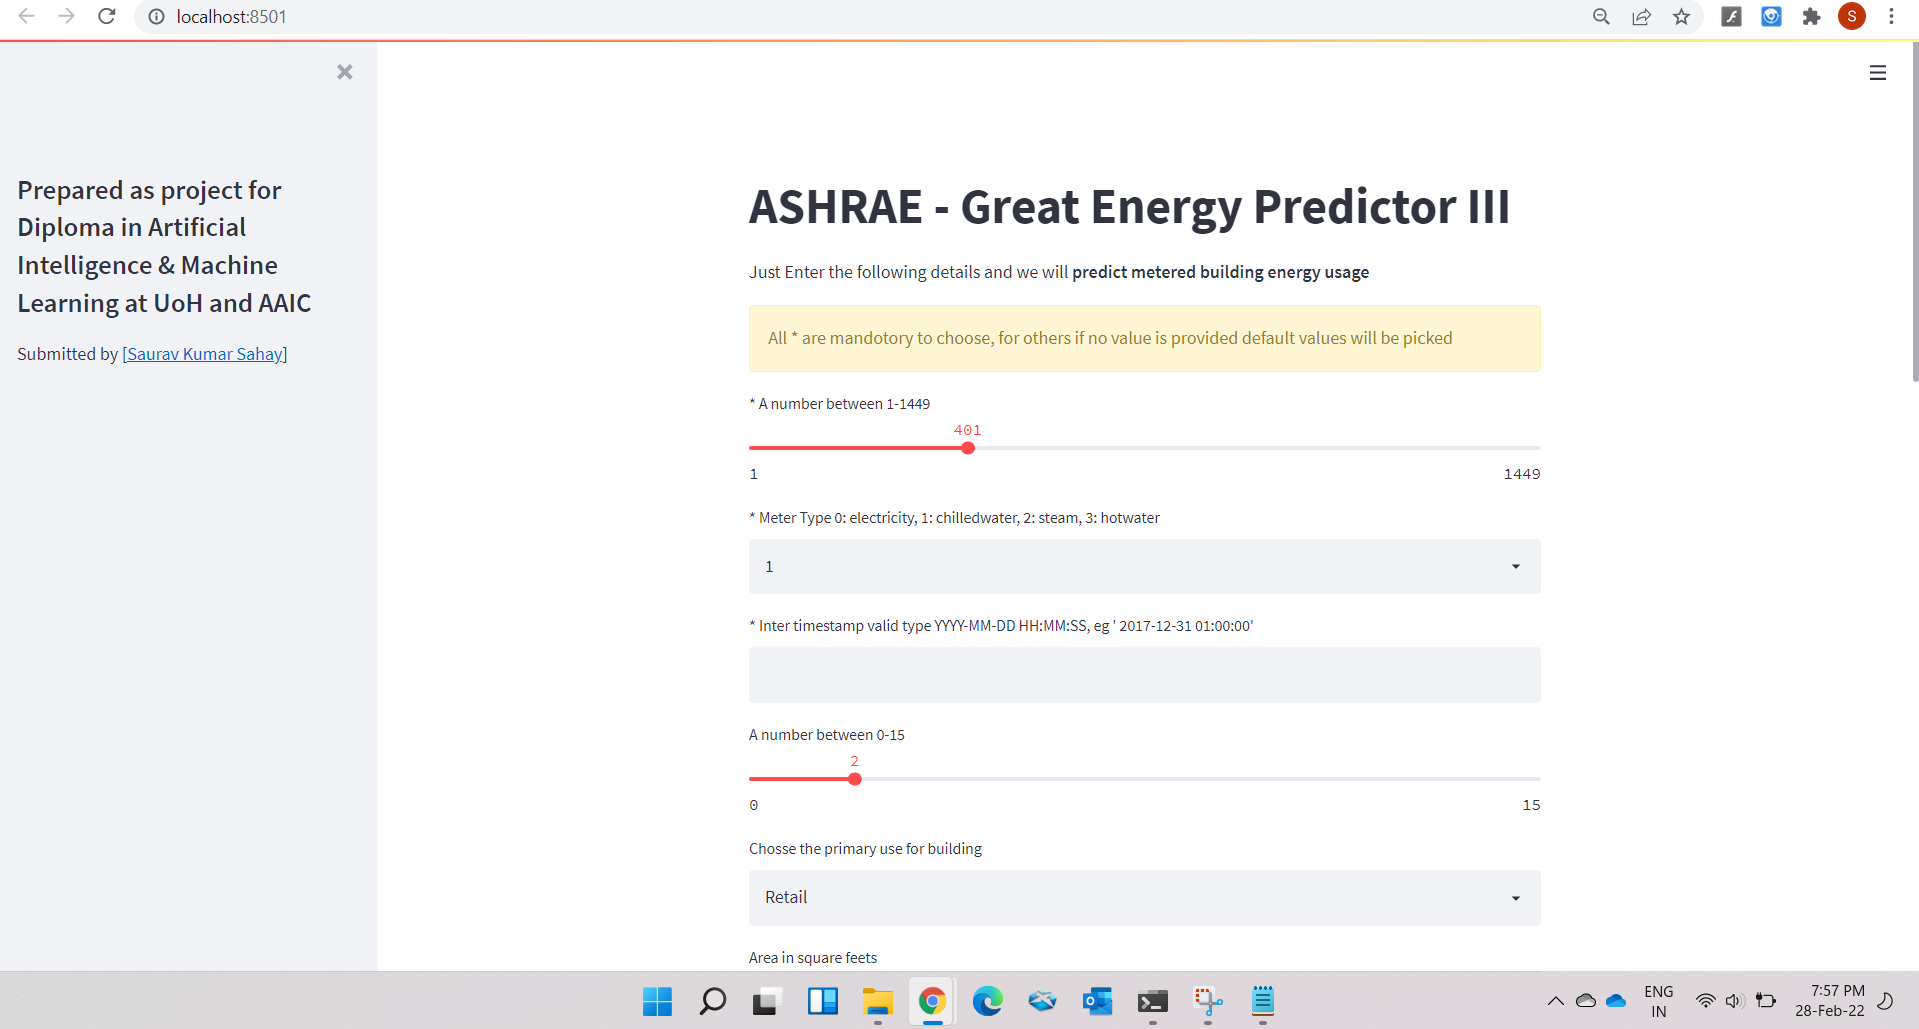

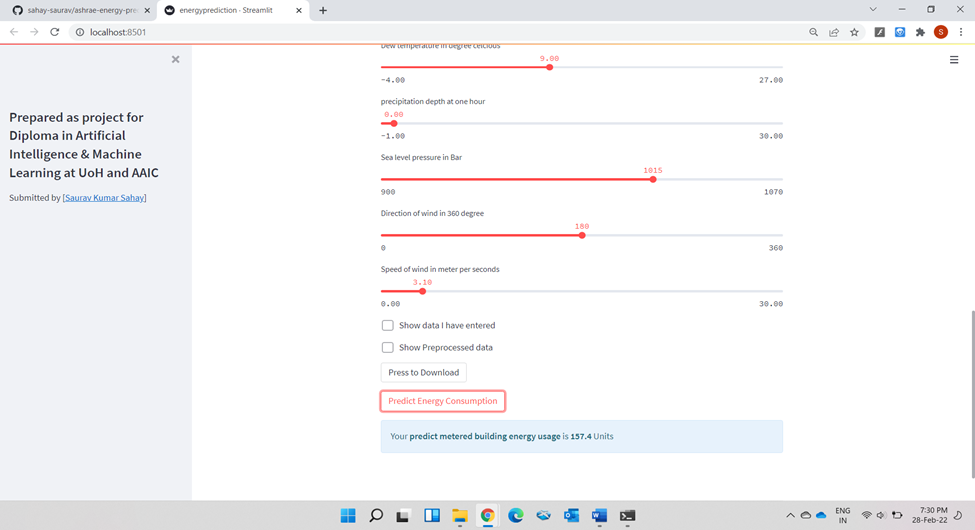

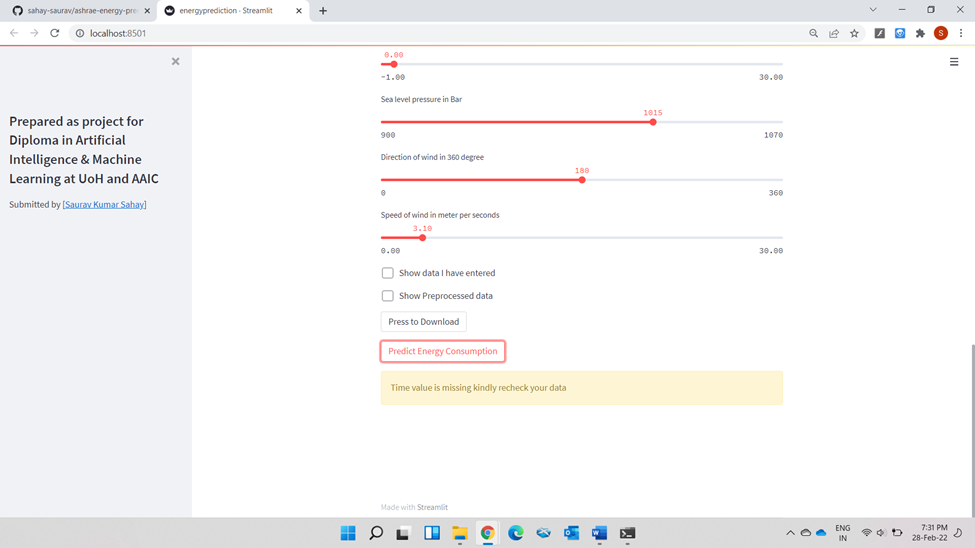